In [88]:
#Importing libraries required to load the data
import zipfile

import pandas as pd
from PIL import Image
import os
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import h5py
import math
import shutil
import glob
import time
import seaborn as sns

from tensorflow import keras
from keras.callbacks import EarlyStopping
#from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, InputLayer
from keras.models import Sequential
from keras.metrics import BinaryAccuracy
from keras.applications import vgg16
from kerastuner.tuners import RandomSearch
from keras_tuner import HyperModel
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import adamax_v2

#from tensorflow.keras.models import Sequential
from tensorflow.keras import backend

import tensorflow as tf
from sklearn.metrics import roc_auc_score

from tensorflow.python.client import device_lib


In [2]:
ZIP_PATH = '../data/cell_images.zip'
#Storing the path of the extracted "train" folder
IMAGE_SOURCE_DIRECTORY = '../data/cell_images'

SMALL_BATCH_DIRECTORY = "../data/cell_images/small_batch"

TRAIN_DIRECTORY = '/train'

VALIDATE_DIRECTORY = '/validate'
#Storing the path of the extracted "test" folder
TEST_DIRECTORY = '/test'

CATEGORY_LIST =['/parasitized', '/uninfected']

H5_FILENAME_PATTERN = '../data/cell_images/cell_image_data_archive_'

MODEL_WEIGHT_PATH = '../data/cell_images/bottleneck_fc_model.h5'

#Size of image so that each image has the same size
IMAGE_SIZE = 224
#Size of image batches for .h5 arhcives

FILE_BATCH_SIZE = 2048

IMAGE_BATCH_SIZE=64

Turn off the GPU, 4 GB of ram isn't large enough to support the CNNs with a large number of images.

In [3]:
tf.config.set_visible_devices([], 'GPU')
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

GPU found


In [4]:
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

Image augmentation code to engineer a wider range of data in the dataset. Each file in the set has a set of different augmentations that are performed on the file.
This augmentation is done via OpenCV. ImageDataGenerator is also used, but mostly for batching and image rotation and skewing to create more variability in the data set.

In [5]:
def image_augmentation_seeding(img, orig_filename, file_directory):

    random_number = np.random.randint(1,4)
    kernel = np.ones((5,5),np.uint8)
    filename_prefix = file_directory+orig_filename.split('/')[5].split('.')[0]

#    print(orig_filename)
#    print(orig_filename.split('/'))

    #print(random_number)
    if  random_number == 1:
        gray_image = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        gray_img_filename = filename_prefix +"_gray.png"
        cv.imwrite(gray_img_filename,gray_image)

        blurred_image = cv.GaussianBlur(gray_image, (3, 3), 0)

        if 'uninfected'  in  orig_filename:
          canny_img = cv.Canny(blurred_image, 10, 200)
          canny_img_filename = filename_prefix +"_canny.png"
          cv.imwrite(canny_img_filename,canny_img)
        else:
          blurred_img_filename = filename_prefix +"_blurred.png"
          cv.imwrite(blurred_img_filename,blurred_image)
    elif random_number == 2:
        erosion_image = cv.erode(img,kernel,iterations = 1)
        erosion_img_filename = filename_prefix + "_erosion.png"
        cv.imwrite(erosion_img_filename,erosion_image)

        dilate_img = cv.dilate(img,kernel,iterations = 1)
        dilate_img_filename = filename_prefix +"_dilate.png"
        cv.imwrite(dilate_img_filename,dilate_img)

    elif random_number == 3:
        opening_img = cv.morphologyEx(img, cv.MORPH_OPEN, kernel)
        opening_img_filename = filename_prefix +"_opening.png"
        cv.imwrite(opening_img_filename,opening_img)

        closing_img = cv.morphologyEx(img, cv.MORPH_CLOSE, kernel)
        closing_img_filename = filename_prefix +"_closing.png"
        cv.imwrite(closing_img_filename,closing_img)
    else:
        # detect circles in the image
        gray_image = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        gray_img_filename = filename_prefix +"_gray.png"
        cv.imwrite(gray_img_filename,gray_image)

        circle_img = img.copy()
        #lurred_image = cv.GaussianBlur(gray_image, (3, 3), 0)
        canny_img = cv.Canny(gray_image, 10, 200)
        circles = cv.HoughCircles(canny_img, cv.HOUGH_GRADIENT, 1, circle_img.shape[0]/8)
        # ensure at least some circles were found

        if circles is not None:
            # convert the (x, y) coordinates and radius of the circles to integers
            circles = np.round(circles[0, :]).astype("int")
            # loop over the (x, y) coordinates and radius of the circles
            for (x, y, r) in circles:
                # draw the circle in the output image, then draw a rectangle
                # corresponding to the center of the circle
                cv.circle(circle_img, (x, y), r, (0, 255, 0), 4)
                #cv.rectangle(circle_img, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)
            # show the output image
            cv.imshow("output", np.hstack([img, circle_img]))
            cv.waitKey(0)
            circle_img_filename = filename_prefix+"_closing.png"
            cv.imwrite(circle_img_filename,circle_img)

In [6]:
def image_open_resize(image_path):
    img = cv.imread(image_path) #read the image from the folder
    resize_img = cv.resize(img,(IMAGE_SIZE, IMAGE_SIZE)) #resize image to 224x224
    return resize_img

In [7]:
#The data is provided as a zip file so we need to extract the files from the zip file
#shutil.rmtree('/content/cell_images/',ignore_errors=True)
if not os.path.isdir(TRAIN_DIRECTORY):
    print("Extracting Files from zip")
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        #zip_ref.extractall("../data/")
        zip_ref.extractall()
        os.mkdir(VALIDATE_DIRECTORY)

        for folder_name in ['/parasitized/', '/uninfected/']:
            image_directory = IMAGE_SOURCE_DIRECTORY + TRAIN_DIRECTORY + folder_name
            images_file_list = glob.glob(image_directory +"*.png")
            print("File count in directory: " + str(len(images_file_list )))
            #Number of images

            for i, image_name in enumerate(images_file_list):
                #try:
                #if image_name.endswith('.png'):
                img = image_open_resize(image_name)
                image_augmentation_seeding(img,image_name,image_directory)

            destination_folder = IMAGE_SOURCE_DIRECTORY + VALIDATE_DIRECTORY + folder_name
            os.mkdir(destination_folder)
            images_file_list = glob.glob(image_directory +"*.png")
            validation_set_size = math.ceil(len(images_file_list)*.2)

            print("New training Set Size: ", len(images_file_list))
            print("Validation Set Size: ", validation_set_size)

            for i in range(validation_set_size):
                random_index = np.random.randint(0, len(images_file_list))
                source_file = images_file_list[random_index]
                shutil.move(source_file, destination_folder)
                images_file_list.remove(source_file)

            print("Training Set Size: ", len(images_file_list))


Extracting Files from zip
File count in directory: 29949


IndexError: list index out of range

Create small batch dataset of randomly selected images for model building and tuning.

In [ ]:
if not os.path.isdir(SMALL_BATCH_DIRECTORY):
        #zip_ref.extractall("../data/")
    os.mkdir(SMALL_BATCH_DIRECTORY)

    for folder_name in CATEGORY_LIST:
        image_directory = IMAGE_SOURCE_DIRECTORY + TRAIN_DIRECTORY+ folder_name
        images_file_list = glob.glob(image_directory +"/*.png")
        print("File count in directory: " + str(len(images_file_list )))
        if not os.path.isdir(SMALL_BATCH_DIRECTORY+ TRAIN_DIRECTORY):
            os.mkdir(SMALL_BATCH_DIRECTORY+ TRAIN_DIRECTORY)

        destination_folder = SMALL_BATCH_DIRECTORY+ TRAIN_DIRECTORY+ folder_name
        os.mkdir(destination_folder)
        train_set_size = math.ceil(len(images_file_list)*.1)

        print("Training Set Size: ", len(images_file_list))
        print("Small Batch Training Set Size: ", train_set_size)

        for i in range(train_set_size):
            random_index = np.random.randint(0, len(images_file_list))
            source_file = images_file_list[random_index]
            shutil.copy(source_file, destination_folder)
            images_file_list.remove(source_file)

    for val_folder_name in CATEGORY_LIST:
        image_directory = IMAGE_SOURCE_DIRECTORY + VALIDATE_DIRECTORY+ val_folder_name
        images_file_list = glob.glob(image_directory +"/*.png")
        print("File count in directory: " + str(len(images_file_list )))
        if not os.path.isdir(SMALL_BATCH_DIRECTORY+ VALIDATE_DIRECTORY):
            os.mkdir(SMALL_BATCH_DIRECTORY+ VALIDATE_DIRECTORY)

        destination_folder = SMALL_BATCH_DIRECTORY+ VALIDATE_DIRECTORY+ val_folder_name
        os.mkdir(destination_folder)
        validation_set_size = math.ceil(len(images_file_list)*.1)

        print("Validation Set Size: ", len(images_file_list))
        print("Small Batch Validation Set Size: ", validation_set_size)

        for i in range(validation_set_size):
            random_index = np.random.randint(0, len(images_file_list))
            source_file = images_file_list[random_index]
            shutil.copy(source_file, destination_folder)
            images_file_list.remove(source_file)

    for test_folder_name in CATEGORY_LIST:
        image_directory = IMAGE_SOURCE_DIRECTORY + TEST_DIRECTORY+ test_folder_name
        images_file_list = glob.glob(image_directory +"/*.png")
        print("File count in directory: " + str(len(images_file_list )))

        if not os.path.isdir(SMALL_BATCH_DIRECTORY+ TEST_DIRECTORY):
            os.mkdir(SMALL_BATCH_DIRECTORY+ TEST_DIRECTORY)

        destination_folder = SMALL_BATCH_DIRECTORY+ TEST_DIRECTORY+ test_folder_name
        os.mkdir(destination_folder)
        test_set_size = math.ceil(len(images_file_list)*.1)

        print("Test Set Size: ", len(images_file_list))
        print("Small Batch Test Set Size: ", test_set_size)

        for i in range(test_set_size):
            random_index = np.random.randint(0, len(images_file_list))
            source_file = images_file_list[random_index]
            shutil.copy(source_file, destination_folder)
            images_file_list.remove(source_file)

Plot the model metrics for Accuracy and Loss for train and validation datasets

In [8]:
def plot_model_run (model_history, epochs_count):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    t = f.suptitle('Model Performance', fontsize=12)
    f.subplots_adjust(top=0.85, wspace=0.3)

    epoch_list = list(range(1,epochs_count+1))
    #ax1.set_facecolor('black')
    ax1.plot(epoch_list, model_history.history['accuracy'], label='Train Accuracy')
    ax1.plot(epoch_list, model_history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_xticks(np.arange(0, epochs_count+1, 5))
    #ax1.tick_params(colors='white')
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy')
    l1 = ax1.legend(loc="best")

    #ax1.set_facecolor('black')
    ax2.plot(epoch_list, model_history.history['loss'], label='Train Loss')
    ax2.plot(epoch_list, model_history.history['val_loss'], label='Validation Loss')
    ax2.set_xticks(np.arange(0, epochs_count+1, 5))
    #ax2.tick_params(colors='white')
    ax2.set_ylabel('Loss Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss')
    l2 = ax2.legend(loc="best")

Confusion Matrix and prediction performance.

In [9]:
def metrics_score(actual, predicted):
    from sklearn.metrics import classification_report
    from sklearn.metrics import confusion_matrix

    #print(actual)
    #print(predicted)

    print(classification_report(actual, predicted))
    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(8,5))
    sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=['unifected','parasitized'], yticklabels=['unifected','parasitized'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

Create ImageDataGenerator for image augmentation and batching

In [10]:
# data generator for training set
train_datagen = ImageDataGenerator(
    rescale = 1./224,
    shear_range = 0.2, # random application of shearing
    zoom_range = 0.2,
    horizontal_flip = True) # randomly flipping half of the images horizontally

# data generator for test set
test_datagen = ImageDataGenerator(rescale = 1./224)

In [11]:
# generator for reading train data from folder
categorical_train_generator = train_datagen.flow_from_directory(
    SMALL_BATCH_DIRECTORY + TRAIN_DIRECTORY,
    target_size = (224, 224),
    color_mode = 'rgb',
    batch_size = 64,
    class_mode = 'categorical')

categorical_tr_parasitized_img_count = len(np.where(categorical_train_generator.labels == 0)[0])
categorical_tr_uninfected_img_count =  len(np.where(categorical_train_generator.labels == 1)[0])

# generator for reading validation data from folder
categorical_validation_generator = test_datagen.flow_from_directory(
    SMALL_BATCH_DIRECTORY + VALIDATE_DIRECTORY,
    target_size = (224, 224),
    color_mode = 'rgb',
    batch_size = 64,
    class_mode = 'categorical')

categorical_val_parasitized_img_count = len(np.where(categorical_validation_generator.labels == 0)[0])
categorical_val_uninfected_img_count =  len(np.where(categorical_validation_generator.labels == 1)[0])

# generator for reading test data from folder
categorical_test_generator = test_datagen.flow_from_directory(
    SMALL_BATCH_DIRECTORY + TEST_DIRECTORY,
    target_size = (224, 224),
    color_mode = 'rgb',
    batch_size = 1,
    class_mode = 'categorical',
    shuffle = False)

categorical_test_files_names = categorical_test_generator.filenames

Found 5990 images belonging to 2 classes.
Found 1498 images belonging to 2 classes.
Found 260 images belonging to 2 classes.


Build a basic CNN Model

In [12]:
# neural network model
categorical_model = Sequential()
categorical_model.add(Conv2D(32, (3,3), input_shape = (224, 224, 3), activation = 'relu'))
categorical_model.add(MaxPooling2D(pool_size = (2,2)))

categorical_model.add(Conv2D(32, (3,3), activation = 'relu'))
categorical_model.add(MaxPooling2D(pool_size = (2,2)))

categorical_model.add(Conv2D(64, (3,3), activation = 'relu'))
categorical_model.add(MaxPooling2D(pool_size=(2,2)))

categorical_model.add(Flatten())
categorical_model.add(Dense(64,activation = 'relu'))
categorical_model.add(Dropout(0.5))
categorical_model.add(Dense(2, activation = 'softmax'))

categorical_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 43264)             0

In [13]:
categorical_model.compile(loss = 'categorical_crossentropy',
              optimizer =  adamax_v2.Adamax(learning_rate=0.005),
              metrics = ['accuracy'])

categorical_history = categorical_model.fit(categorical_train_generator,
                    steps_per_epoch = categorical_train_generator.n//categorical_train_generator.batch_size,
                    validation_steps = categorical_validation_generator.n//categorical_validation_generator.batch_size,
                    epochs = 30,
                    validation_data = categorical_validation_generator)

Epoch 1/30
93/93 [==============================] - 107s 1s/step - loss: 0.8413 - accuracy: 0.5531 - val_loss: 0.6474 - val_accuracy: 0.6101

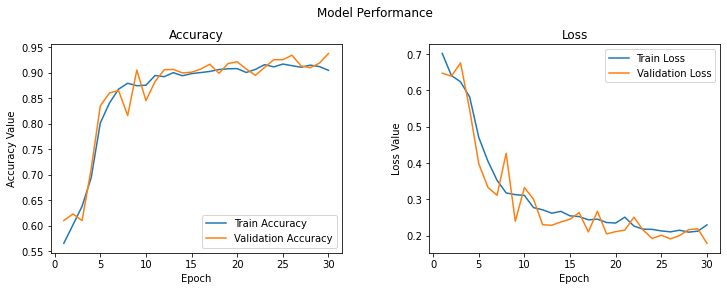

In [16]:
plot_model_run(categorical_history,len(categorical_history.epoch))

In [17]:
# AUC for prediction on validation sample
categorical_X_val_sample, categorical_val_labels = next(categorical_validation_generator)

In [18]:
categorical_val_pred = categorical_model.predict(categorical_X_val_sample)
categorical_val_pred = np.reshape(categorical_val_pred, categorical_val_labels.shape)
categorical_val_score_auc = roc_auc_score(categorical_val_labels, categorical_val_pred)
print ("AUC validation score")
print (categorical_val_score_auc)

AUC validation score
0.9823529411764705


In [19]:
categorical_val_pred = categorical_model.predict(categorical_X_val_sample)
categorical_val_pred = np.reshape(categorical_val_pred, categorical_val_labels.shape)
categorical_val_score_auc = roc_auc_score(categorical_val_labels, categorical_val_pred)
print ("AUC validation score")
print (categorical_val_score_auc)

AUC validation score
0.9823529411764705


In [21]:
# test predictions with generator
categorical_test_files_names = categorical_test_generator.filenames
categorical_predictions = categorical_model.predict(categorical_test_generator, steps = categorical_test_generator.n)

In [22]:
categorical_predictions_df = pd.DsataFrame(categorical_predictions, columns = ['parasitized','uninfected'])
categorical_predictions_df.insert(0, "name", categorical_test_files_names)
#predictions_df['name'] = predictions_df['name'].map(lambda x: x.lstrip('test\\').rstrip('.jpg'))
#predictions_df['name'] = pd.to_numeric(predictions_df['name'], errors = 'coerce')
categorical_predictions_df.sort_values('name', inplace = True)
categorical_predictions_df.to_csv('category_predictions_df.csv', index = False)

              precision    recall  f1-score   support

           0       0.96      0.92      0.94       130
           1       0.93      0.96      0.94       130

    accuracy                           0.94       260
   macro avg       0.94      0.94      0.94       260
weighted avg       0.94      0.94      0.94       260



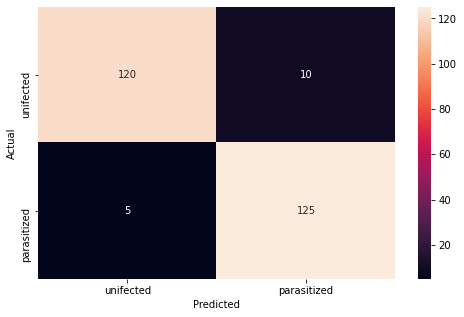

In [23]:
categorical_predictions_round = np.round(categorical_predictions[:,1]).astype(np.int32)
#print(categorical_predictions_round)
#print(categorical_test_generator.labels)
metrics_score(categorical_test_generator.labels, categorical_predictions_round)

Observations:
Should run more epochs to trian the model more. The skew towards the false positives is acceptable but overall the F-Score is low. More training could improve this model.

Build Basic CNN with Binary Cross Entropy and Sigmoid output.
- Besides, the actual CNN itself the major difference in the solution is the way we label the images. The images are not labeled via class labels but as single column bool, 0 = class A (parasitized) and 1 = (uninfected)
- The output on the for the model has been adjusted to give a prediction percentage instead of the raw score.

In [24]:
backend.clear_session()

In [25]:
binary_train_datagen = ImageDataGenerator(
    rescale = 1./224,
    shear_range = 0.2, # random application of shearing
    zoom_range = 0.2,
    horizontal_flip = True) # randomly flipping half of the images horizontally

# data generator for test set
binary_test_datagen = ImageDataGenerator(rescale = 1./224)

In [26]:
# generator for reading train data from folder
binary_train_generator = binary_train_datagen.flow_from_directory(
    SMALL_BATCH_DIRECTORY + TRAIN_DIRECTORY,
    target_size = (224, 224),
    color_mode = 'rgb',
    batch_size = 64,
    class_mode = 'binary')

binary_tr_parasitized_img_count = len(np.where(binary_train_generator.labels == 0)[0])
binary_tr_uninfected_img_count =  len(np.where(binary_train_generator.labels == 1)[0])

# generator for reading validation data from folder
binary_validation_generator = binary_train_datagen.flow_from_directory(
    SMALL_BATCH_DIRECTORY + VALIDATE_DIRECTORY,
    target_size = (224, 224),
    color_mode = 'rgb',
    batch_size = 64,
    class_mode = 'binary')

binary_val_parasitized_img_count = len(np.where(binary_validation_generator.labels == 0)[0])
binary_val_uninfected_img_count =  len(np.where(binary_validation_generator.labels == 1)[0])

# generator for reading test data from folder
binary_test_generator = binary_test_datagen.flow_from_directory(
    SMALL_BATCH_DIRECTORY + TEST_DIRECTORY,
    target_size = (224, 224),
    color_mode = 'rgb',
    batch_size = 1,
    class_mode = 'binary',
    shuffle = False)

binary_test_files_names = binary_test_generator.filenames

Found 5990 images belonging to 2 classes.
Found 1498 images belonging to 2 classes.
Found 260 images belonging to 2 classes.


In [27]:

# neural network model
binary_model = Sequential()
binary_model.add(Conv2D(32, (3,3), input_shape = (224, 224, 3), activation = 'relu'))
binary_model.add(MaxPooling2D(pool_size = (2,2)))

binary_model.add(Conv2D(32, (3,3), activation = 'relu'))
binary_model.add(MaxPooling2D(pool_size = (2,2)))

binary_model.add(Conv2D(64, (3,3), activation = 'relu'))
binary_model.add(MaxPooling2D(pool_size=(2,2)))

binary_model.add(Flatten())
binary_model.add(Dense(64,activation = 'relu'))
binary_model.add(Dropout(0.5))
binary_model.add(Dense(1, activation = 'sigmoid'))

binary_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 43264)             0

In [28]:
binary_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer =  adamax_v2.Adamax(learning_rate=0.005),
              metrics = ['accuracy'])

binary_history = binary_model.fit(binary_train_generator,
                    steps_per_epoch = binary_train_generator.n//binary_train_generator.batch_size,
                    validation_steps = binary_validation_generator.n//binary_validation_generator.batch_size,
                    epochs = 30,
                    validation_data = binary_validation_generator)

Epoch 1/30


C:\Users\mattb\anaconda3\lib\site-packages\tensorflow\python\keras\backend.py:5016: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


93/93 [==============================] - 109s 1s/step - loss: 1.1691 - accuracy: 0.5421 - val_loss: 0.6519 - val_accuracy: 0.5679

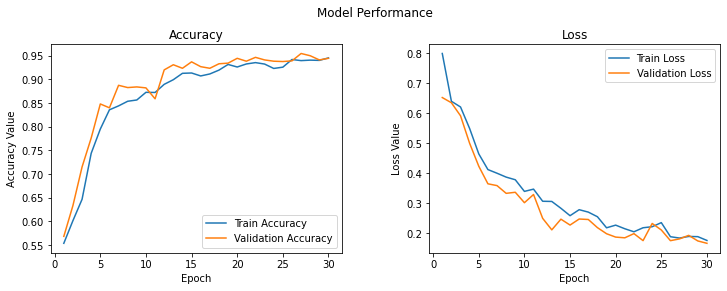

In [30]:
plot_model_run(binary_history,len(binary_history.epoch))

In [31]:
# AUC for prediction on validation sample
binary_X_val_sample, binary_val_labels = next(binary_validation_generator)

In [32]:
binary_val_pred = binary_model.predict(binary_X_val_sample)
binary_val_pred = np.reshape(binary_val_pred, binary_val_labels.shape)
binary_val_score_auc = roc_auc_score(binary_val_labels, binary_val_pred)
print ("AUC validation score")
print (binary_val_score_auc)

AUC validation score
0.9704433497536946


In [33]:
binary_val_pred = binary_model.predict(binary_X_val_sample)
binary_val_pred = np.reshape(binary_val_pred, binary_val_labels.shape)
binary_val_score_auc = roc_auc_score(binary_val_labels, binary_val_pred)
print ("AUC validation score")
print (binary_val_score_auc)

AUC validation score
0.9704433497536946


In [35]:
# test predictions with generator
binary_test_files_names = binary_test_generator.filenames
binary_predictions = binary_model.predict(binary_test_generator, steps = binary_test_generator.n)

In [36]:
binary_predictions_df = pd.DataFrame(binary_predictions, columns = ['uninfected'])
binary_predictions_df.insert(0, "name", binary_test_files_names)
#predictions_df['name'] = predictions_df['name'].map(lambda x: x.lstrip('test\\').rstrip('.jpg'))
#predictions_df['name'] = pd.to_numeric(predictions_df['name'], errors = 'coerce')
binary_predictions_df.sort_values('name', inplace = True)
binary_predictions_df.to_csv('binary_predictions_df.csv', index = False)

              precision    recall  f1-score   support

           0       0.97      0.92      0.94       130
           1       0.93      0.97      0.95       130

    accuracy                           0.95       260
   macro avg       0.95      0.95      0.95       260
weighted avg       0.95      0.95      0.95       260



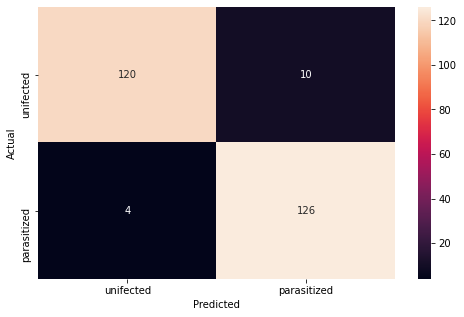

In [37]:
binary_predictions_round = np.round(binary_predictions).astype(np.int32)
metrics_score(binary_test_generator.labels, binary_predictions_round)

Overall this model is performing better than the previous one, still a very low which is acceptable but the model will need to be more accurate to assist the purpose it was intended for.

Build a transfer learning model with VGG-16 functioning as the feature extractor, this reduces the execution time for the entire model and allows more features to be extract with fewer resources.

In [38]:
backend.clear_session()

In [39]:
#def save_bottlebeck_features():
learner_datagen = ImageDataGenerator(rescale=1. / 224)

# build the VGG16 network
learner_model = vgg16.VGG16(include_top=False, weights='imagenet')

learn_train_generator = learner_datagen.flow_from_directory(
    SMALL_BATCH_DIRECTORY + TRAIN_DIRECTORY,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=10,
    class_mode=None,
    shuffle=False)

learn_tr_parasitized_img_count = len(np.where(learn_train_generator.labels == 0)[0])
learn_tr_uninfected_img_count =  len(np.where(learn_train_generator.labels == 1)[0])

learn_validate_generator = learner_datagen.flow_from_directory(
    SMALL_BATCH_DIRECTORY + VALIDATE_DIRECTORY,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=10,
    class_mode=None,
    shuffle=False)

learn_val_parasitized_img_count = len(np.where(learn_validate_generator.labels == 0)[0])
learn_val_uninfected_img_count =  len(np.where(learn_validate_generator.labels == 1)[0])

learn_test_generator = learner_datagen.flow_from_directory(
    SMALL_BATCH_DIRECTORY + TEST_DIRECTORY,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=1,
    class_mode=None,
    shuffle=False)

learn_test_files_names = learn_test_generator.filenames

Found 5990 images belonging to 2 classes.
Found 1498 images belonging to 2 classes.
Found 260 images belonging to 2 classes.


In [40]:
vgg = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(224,224,3))
output = vgg.layers[-1].output
output = Flatten()(output)
vgg_model = Model(vgg.input, output)

vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False

In [41]:
vgg_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [42]:

shutil.rmtree('bottleneck_features_train.npy', ignore_errors=True)

bottleneck_features_train = vgg_model.predict(learn_train_generator,  learn_train_generator.n//learn_train_generator.batch_size)

np.save(open('bottleneck_features_train.npy', 'wb'), bottleneck_features_train)

shutil.rmtree('bottleneck_features_validation.npy', ignore_errors=True)
bottleneck_features_validation = vgg_model.predict(learn_validate_generator, learn_validate_generator.n//learn_validate_generator.batch_size)

np.save(open('bottleneck_features_validation.npy', 'wb'), bottleneck_features_validation)


In [43]:
#def train_top_model():
learner_train_data = np.load(open('bottleneck_features_train.npy',mode='rb'))
learner_validation_data = np.load(open('bottleneck_features_validation.npy',mode='rb'))

In [44]:
learner_train_labels = np.array(
    [1] * (learn_tr_parasitized_img_count) + [0] * (learn_tr_uninfected_img_count))

learner_validation_labels = np.array(
    [1] * (learn_val_parasitized_img_count) + [0] * (learn_val_uninfected_img_count))


In [45]:
input_shape = vgg_model.output_shape[1]
print(input_shape)

25088


In [46]:
learner_model = Sequential()
#learner_model.add(vgg_model)
learner_model.add(InputLayer(input_shape=(input_shape,)))
learner_model.add(Dense(512, activation='relu', input_dim=(224,224,3)))
learner_model.add(Dropout(0.3))
learner_model.add(Dense(512, activation='relu'))
learner_model.add(Dropout(0.3))
learner_model.add(Dense(1, activation='sigmoid'))

learner_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
          optimizer =  adamax_v2.Adamax(learning_rate=0.005),
          metrics = ['accuracy'])

learner_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               12845568  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 13,108,737
Trainable params: 13,108,737
Non-trainable params: 0
_________________________________________________________________


In [47]:
learner_history = learner_model.fit(x=learner_train_data,y=learner_train_labels,
          steps_per_epoch = learn_train_generator.n//learn_train_generator.batch_size,
          #validation_steps = learn_validate_generator.n//learn_validate_generator.batch_size,
          epochs = 30,
          #validation_freq = 1,
          validation_data=(learner_validation_data,learner_validation_labels))

#learner_model.save_weights(MODEL_WEIGHT_PATH)

Epoch 1/30


C:\Users\mattb\anaconda3\lib\site-packages\tensorflow\python\keras\backend.py:5016: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


599/599 [==============================] - 23s 36ms/step - loss: 2.4472 - accuracy: 0.7037 - val_loss: 0.3627 - val_accuracy: 0.8378

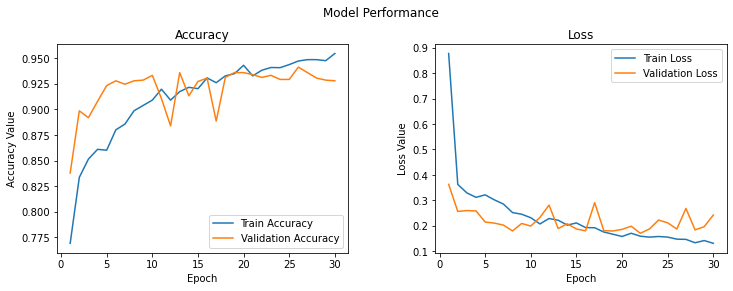

In [48]:
plot_model_run(learner_history,len(learner_history.epoch))

In [49]:
#X_train_val_sample, train_val_labels = next(validate_generator)
learn_acc_data = []
learn_acc_lables = []

for i in range(64):
  random_index = np.random.randint(0, len(learner_validation_data))
  learn_acc_data.append(learner_validation_data[random_index])
  learn_acc_lables.append(learner_validation_labels[random_index])

learn_acc_data = np.array(learn_acc_data)
learn_acc_lables = np.array(learn_acc_lables)


In [50]:
learner_val_pred = learner_model.predict(learn_acc_data)
learner_val_pred = np.reshape(learner_val_pred, learn_acc_lables.shape)
learner_val_score_auc = roc_auc_score(learn_acc_lables, learner_val_pred)
print ("AUC validation score")
print (learner_val_score_auc)

AUC validation score
0.9599609375


In [51]:
learner_val_pred2 = learner_model.predict(learn_acc_data)
learner_val_pred2 = np.reshape(learner_val_pred2, learn_acc_lables.shape)
learner_val_score_auc2 = roc_auc_score(learn_acc_lables, learner_val_pred2)
print ("AUC validation score")
print (learner_val_score_auc2)

AUC validation score
0.9599609375


In [52]:
learn_test_bottleneck_features = vgg_model.predict(learn_test_generator)
learn_predictions = learner_model.predict(learn_test_bottleneck_features)

In [53]:
# test predictions with generator
learn_predictions_df = pd.DataFrame(learn_predictions, columns = ['parasitized'])
learn_predictions_df.insert(0, "name", learn_test_files_names)
#predictions_df['name'] = predictions_df['name'].map(lambda x: x.lstrip('test\\').rstrip('.jpg'))
#predictions_df['name'] = pd.to_numeric(predictions_df['name'], errors = 'coerce')
learn_predictions_df.sort_values('name', inplace = True)
learn_predictions_df.to_csv('learn_predictions_df.csv', index = False)


              precision    recall  f1-score   support

           0       0.93      0.95      0.94       130
           1       0.95      0.93      0.94       130

    accuracy                           0.94       260
   macro avg       0.94      0.94      0.94       260
weighted avg       0.94      0.94      0.94       260



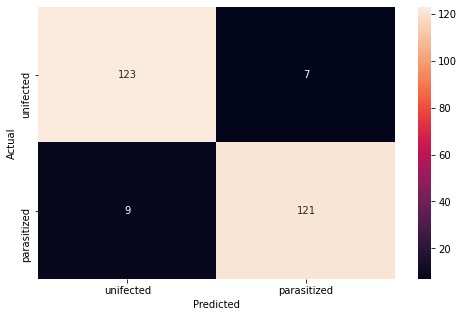

In [54]:
learn_predictions_round = np.round((1-np.round(learn_predictions,1)[:])).astype(np.int32)
metrics_score(learn_test_generator.labels, learn_predictions_round)

Observations:
For very little effort or guess work we have a model that preforms very well with very little training. This model could use more training but this model would probably not benefit much from training over very large datasets.

Build a hyperparameter tuning model. This effort would/will reduce a significant amount of the guess work out of building a CNN model.
Creating models this way would still be time-consuming and expensive, however the resource would be spent in cpu cycling and compute not man-hours.
This effort seems to lay at the opposite end of the specture from transfer learning.

In [55]:
backend.clear_session()

In [56]:
hyper_train_generator = train_datagen.flow_from_directory(
    SMALL_BATCH_DIRECTORY + TRAIN_DIRECTORY,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=IMAGE_BATCH_SIZE,
    class_mode='binary')

hyper_validate_generator = train_datagen.flow_from_directory(
    SMALL_BATCH_DIRECTORY + VALIDATE_DIRECTORY,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=IMAGE_BATCH_SIZE,
    class_mode='binary')

hyper_test_generator = test_datagen.flow_from_directory(
    SMALL_BATCH_DIRECTORY + TEST_DIRECTORY,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=1,
    class_mode='binary',
    shuffle=False)

hyper_test_files_names =hyper_test_generator.filenames

Found 5990 images belonging to 2 classes.
Found 1498 images belonging to 2 classes.
Found 260 images belonging to 2 classes.


In [57]:
class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        model = Sequential()
        model.add(Conv2D(filters=32,kernel_size=3,activation='relu',input_shape=self.input_shape))
        model.add(Conv2D(filters=32,activation='relu',kernel_size=3))
        model.add(MaxPooling2D(pool_size=2))

        model.add(Conv2D(filters=hp.Choice('num_filters_1',values=[32, 64],default=64,),activation='relu',kernel_size=3))
        model.add(Conv2D(filters=hp.Choice('num_filters_2',values=[32, 64],default=64,),activation='relu',kernel_size=3))
        model.add(MaxPooling2D(pool_size=2))

        model.add(Flatten())
        model.add(Dense(units=hp.Int('units_1',min_value=32,max_value=512,step=32,default=128),
                activation=hp.Choice('dense_activation_1',values=['relu', 'tanh', 'sigmoid'],default='relu')))
        model.add(Dropout(rate=hp.Float('dropout_1',min_value=0.0,max_value=0.5,default=0.25,step=0.05)))
        model.add(Dense(1, activation='sigmoid'))

        model.compile(
            optimizer='adam',
            #adamax_v2.Adamax(hp.Float('learning_rate',min_value=1e-4,max_value=1e-2,sampling='LOG',default=1e-3)),
            loss='binary_crossentropy',
            metrics=['accuracy'])
        return model

In [58]:
hypermodel = CNNHyperModel(input_shape=(224,224,3), num_classes=1)

In [62]:
tuner = RandomSearch(
    hypermodel,
    objective="val_accuracy",
    max_trials=10,
    overwrite=True,
    directory=IMAGE_SOURCE_DIRECTORY,
    project_name="deeplearning",
)

#for nextData in binary_train_generator.next():

#x_train, y_train = binary_train_generator.next()
# = binary_train_generator.labels
tuner.search(hyper_train_generator, epochs=10, validation_data=hyper_validate_generator)

Trial 10 Complete [00h 40m 27s]
val_accuracy: 0.8991989493370056

Best val_accuracy So Far: 0.9085447192192078
Total elapsed time: 07h 17m 59s
INFO:tensorflow:Oracle triggered exit


In [71]:
best_hps = tuner.get_best_hyperparameters()[0]
print(best_hps)

print(best_hps.values)
backend.clear_session()

{'num_filters_1': 32, 'num_filters_2': 64, 'units_1': 256, 'dense_activation_1': 'tanh', 'dropout_1': 0.30000000000000004}


In [72]:
hyper_params_model = tuner.hypermodel.build(best_hps)

In [73]:
hyper_params_model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.

In [74]:
history = hyper_params_model.fit(hyper_train_generator,
                    epochs=30,
                    validation_data=hyper_validate_generator)

Epoch 1/30
94/94 [==============================] - 288s 3s/step - loss: 0.9793 - accuracy: 0.5417 - val_loss: 0.6374 - val_accuracy: 0.6035

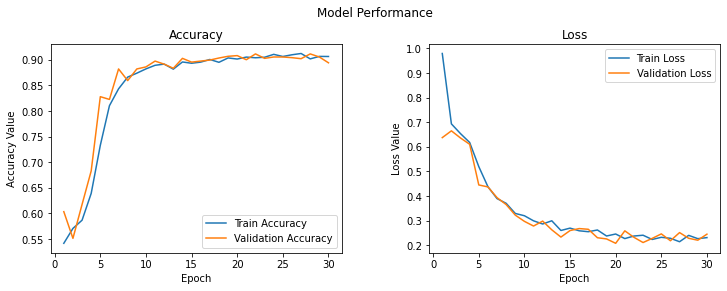

In [75]:
plot_model_run(history,len(history.epoch))

In [76]:
hyper_X_val_sample, hyper_val_labels = next(hyper_validate_generator)

In [77]:
hyper_val_pred = hyper_params_model.predict(hyper_X_val_sample)
hyper_val_pred = np.reshape(hyper_val_pred, hyper_val_labels.shape)
hyper_val_score_auc = roc_auc_score(hyper_val_labels, hyper_val_pred)
print ("AUC validation score")
print (hyper_val_score_auc)

AUC validation score
0.9676470588235295


In [78]:
hyper_val_pred2 = hyper_params_model.predict(hyper_X_val_sample)
hyper_val_pred2 = np.reshape(hyper_val_pred2, hyper_val_labels.shape)
hyper_val_score_auc2 = roc_auc_score(hyper_val_labels, hyper_val_pred2)
print ("AUC validation score")
print (hyper_val_score_auc2)

AUC validation score
0.9676470588235295


In [79]:
hyper_predictions = hyper_params_model.predict(hyper_test_generator)

In [80]:
# test predictions with generator
hyper_predictions_df = pd.DataFrame(hyper_predictions, columns = ['parasitized'])
hyper_predictions_df.insert(0, "name", hyper_test_files_names)
#predictions_df['name'] = predictions_df['name'].map(lambda x: x.lstrip('test\\').rstrip('.jpg'))
#predictions_df['name'] = pd.to_numeric(predictions_df['name'], errors = 'coerce')
hyper_predictions_df.sort_values('name', inplace = True)
hyper_predictions_df.to_csv('hyper_predictions_df.csv', index = False)

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       130
           1       0.93      0.93      0.93       130

    accuracy                           0.93       260
   macro avg       0.93      0.93      0.93       260
weighted avg       0.93      0.93      0.93       260



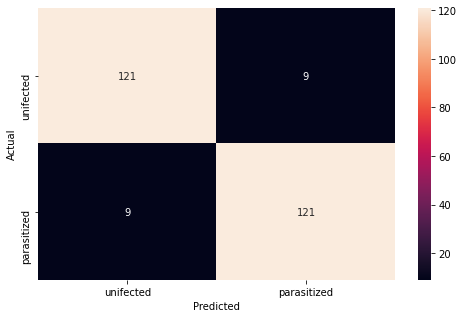

In [81]:
hyper_predictions_round = np.round(hyper_predictions).astype(np.int32)
metrics_score(hyper_test_generator.labels, hyper_predictions_round)

Create a model that will use callbacks to stop the model during training once the model training stops improving a "suffienct" rate, i.e. that could be defined by increased accuracy or the minimizing the loss.
Callback coupled with hyperparameter tuning make the most sense when trying to be efficient with compute resources. The only issue with stoping the model early is not knowing if you've stopped at a local minimum.

In [89]:
backend.clear_session()

In [ ]:
class LossAndErrorPrintingCallback(keras.callbacks.Callback):
    # def on_train_batch_end(self, batch, logs=None):
    #     print(
    #         "Up to batch {}, the average loss is {:7.2f}.".format(batch, logs["loss"])
    #     )
    #
    # def on_test_batch_end(self, batch, logs=None):
    #     print(
    #         "Up to batch {}, the average loss is {:7.2f}.".format(batch, logs["loss"])
    #     )

    def on_epoch_end(self, epoch, logs=None):
        print(epoch)
        print(logs)
        print(
            "The average loss for epoch {} is {:7.2f} "
            "and mean absolute error is {:7.2f}.".format(
                epoch, logs["loss"], logs["mean_absolute_error"]
            )
        )

In [ ]:
class EarlyStoppingAtMinLoss(keras.callbacks.Callback):
    """Stop training when the loss is at its min, i.e. the loss stops decreasing.

  Arguments:
      patience: Number of epochs to wait after min has been hit. After this
      number of no improvement, training stops.
  """

    def __init__(self, patience=0):
        super(EarlyStoppingAtMinLoss, self).__init__()
        self.patience = patience
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("loss")
        if np.less(current, self.best):
            self.best = current
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))



In [90]:
callback_train_datagen = ImageDataGenerator(
    rescale = 1./224,
    shear_range = 0.2, # random application of shearing
    zoom_range = 0.2,
    horizontal_flip = True) # randomly flipping half of the images horizontally

# data generator for test set
callback_test_datagen = ImageDataGenerator(rescale = 1./224)

In [91]:
# generator for reading train data from folder
callback_train_generator = callback_train_datagen.flow_from_directory(
    SMALL_BATCH_DIRECTORY + TRAIN_DIRECTORY,
    target_size = (224, 224),
    color_mode = 'rgb',
    batch_size = 64,
    class_mode = 'binary')

callback_tr_parasitized_img_count = len(np.where(callback_train_generator.labels == 0)[0])
callback_tr_uninfected_img_count =  len(np.where(callback_train_generator.labels == 1)[0])

# generator for reading validation data from folder
callback_validation_generator = callback_train_datagen.flow_from_directory(
    SMALL_BATCH_DIRECTORY + VALIDATE_DIRECTORY,
    target_size = (224, 224),
    color_mode = 'rgb',
    batch_size = 64,
    class_mode = 'binary')

callback_val_parasitized_img_count = len(np.where(callback_validation_generator.labels == 0)[0])
callback_val_uninfected_img_count =  len(np.where(callback_validation_generator.labels == 1)[0])

# generator for reading test data from folder
callback_test_generator = callback_test_datagen.flow_from_directory(
    SMALL_BATCH_DIRECTORY + TEST_DIRECTORY,
    target_size = (224, 224),
    color_mode = 'rgb',
    batch_size = 1,
    class_mode = 'binary',
    shuffle = False)

callback_test_files_names = callback_test_generator.filenames

Found 5990 images belonging to 2 classes.
Found 1498 images belonging to 2 classes.
Found 260 images belonging to 2 classes.


In [92]:
# neural network model
callback_model = Sequential()
callback_model.add(Conv2D(32, (3,3), input_shape = (224, 224, 3), activation = 'relu'))
callback_model.add(MaxPooling2D(pool_size = (2,2)))

callback_model.add(Conv2D(32, (3,3), activation = 'relu'))
callback_model.add(MaxPooling2D(pool_size = (2,2)))

callback_model.add(Conv2D(64, (3,3), activation = 'relu'))
callback_model.add(MaxPooling2D(pool_size=(2,2)))

callback_model.add(Flatten())
callback_model.add(Dense(64,activation = 'relu'))
callback_model.add(Dropout(0.5))
callback_model.add(Dense(1, activation = 'sigmoid'))

callback_model.summary()

callback_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer =  adamax_v2.Adamax(learning_rate=0.005),
              metrics = ['accuracy','mean_absolute_error'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 43264)             0

In [93]:
early_stopping = EarlyStopping(
    patience=3,
    verbose=1,
    restore_best_weights=False)# by default, monitor='val_loss' and patience=1

In [94]:
callback_history = callback_model.fit(callback_train_generator,
                    steps_per_epoch = callback_train_generator.n//callback_train_generator.batch_size,
                    validation_steps = callback_validation_generator.n//callback_validation_generator.batch_size,
                    epochs = 100,
                    validation_data = callback_validation_generator,
                    callbacks=[
                        early_stopping
                        # LossAndErrorPrintingCallback(),
                        # EarlyStoppingAtMinLoss()
                    ])

Epoch 1/100


C:\Users\mattb\anaconda3\lib\site-packages\tensorflow\python\keras\backend.py:5016: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


93/93 [==============================] - 110s 1s/step - loss: 0.8127 - accuracy: 0.5495 - mean_absolute_error: 0.4767 - val_loss: 0.6542 - val_accuracy: 0.5537 - val_mean_absolute_error: 0.4670

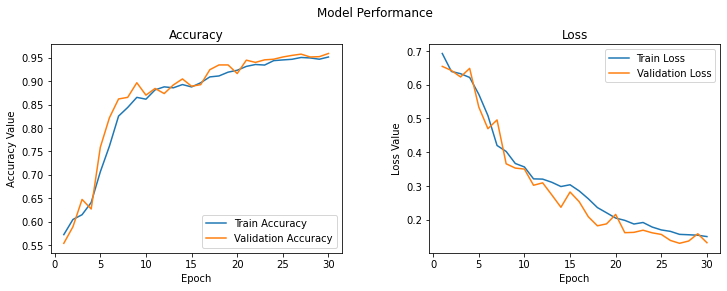

In [95]:
plot_model_run(callback_history,len(callback_history.epoch))

In [96]:
# AUC for prediction on validation sample
callbacks_X_val_sample, callbacks_val_labels = next(callback_validation_generator)

In [98]:
callbacks_val_pred = callback_model.predict(callbacks_X_val_sample)
callbacks_val_pred = np.reshape(callbacks_val_pred, callbacks_val_labels.shape)
callbacks_val_score_auc = roc_auc_score(callbacks_val_labels, callbacks_val_pred)
print ("AUC validation score")
print (callbacks_val_score_auc)

AUC validation score
0.9605263157894737


In [99]:
callbacks_val_pred = callback_model.predict(callbacks_X_val_sample)
callbacks_val_pred = np.reshape(callbacks_val_pred, callbacks_val_labels.shape)
callbacks_val_score_auc = roc_auc_score(callbacks_val_labels, callbacks_val_pred)
print ("AUC validation score")
print (callbacks_val_score_auc)

AUC validation score
0.9605263157894737


In [100]:
# test predictions with generator
callbacks_test_files_names = callback_test_generator.filenames
callbacks_predictions = callback_model.predict(callback_test_generator, steps = callback_test_generator.n)

In [101]:
callbacks_predictions_df = pd.DataFrame(callbacks_predictions, columns = ['uninfected'])
callbacks_predictions_df.insert(0, "name", callbacks_test_files_names)
#predictions_df['name'] = predictions_df['name'].map(lambda x: x.lstrip('test\\').rstrip('.jpg'))
#predictions_df['name'] = pd.to_numeric(predictions_df['name'], errors = 'coerce')
callbacks_predictions_df.sort_values('name', inplace = True)
callbacks_predictions_df.to_csv('callbacks_predictions_df.csv', index = False)

              precision    recall  f1-score   support

           0       0.98      0.92      0.95       130
           1       0.93      0.98      0.96       130

    accuracy                           0.95       260
   macro avg       0.96      0.95      0.95       260
weighted avg       0.96      0.95      0.95       260



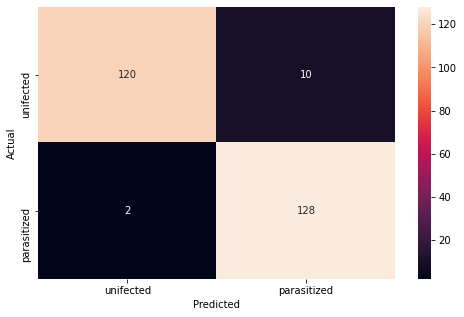

In [102]:
callbacks_predictions_round = np.round(callbacks_predictions).astype(np.int32)
metrics_score(callback_test_generator.labels, callbacks_predictions_round)